# HR Data Analysis
    a.	Preprocess and clean if necessary.
    b.	Build a model predicting “attriction”. 
    c.	Remember to comment your code and give rationales for models, algorithms, and approaches. 


## Import Packages

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Load data

In [9]:
import pyodbc
import urllib
import sqlalchemy

'''connect to datahub'''

params_datahub = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))

df=pd.read_sql_table(r"HR_Employee_Attrition",engine_datahub)
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


<AxesSubplot:>

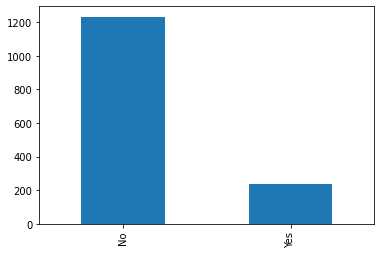

In [3]:

df['Attrition'].value_counts().plot(kind='bar')

## Data processing and cleaning

In [10]:
df=pd.read_sql_table(r"HR_Employee_Attrition",engine_datahub)
df.info()


num_cols=df.select_dtypes('number').drop(['EmployeeNumber'],axis=1).columns.tolist()

cat_cols=df.select_dtypes(object).drop(['Attrition','JobRole','EducationField'],axis=1).columns.tolist()

df[num_cols]=df[num_cols].clip(lower=df[num_cols].quantile(0.01), upper=df[num_cols].quantile(0.99),axis=1)

df=df.query('`Attrition`.notnull()',engine='python')

#replace mnissing value with median, a better representation of the center of the data if it's not normally ditributed

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
for col in num_cols:
    df[col]=imputer.fit_transform(df[col].values.reshape(-1, 1))



imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for col in cat_cols:
    df[col]=imputer.fit_transform(df[col].values.reshape(-1, 1))

# c='Purpose'
# percentage=5
# dct={}
# series = pd.value_counts(df[c])
# mask = (series/series.sum() * 100).lt(percentage)             
# dct[c] = series[mask].index.values.tolist()
# dct[c]
# df[c] = np.where(df[c].isin(dct[c]),'Other',df[c])
# df[c].value_counts()

unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
# unique_counts

df.query('`Attrition`.notnull()',engine='python')

#check for missing values
df[df.isnull().any(axis=1)]

#encode the attribute
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([each], axis=1)
    return df


# cat_cols.remove('Attrition')
df=one_hot(df,cat_cols)
df.head()

item_list = df.columns.tolist()
item_list = [e for e in item_list if e not in ('Attrition','EmployeeNumber','JobRole','EducationField')]
item_list

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

['Age',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EmployeeCount',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'BusinessTravel_Non-Travel',
 'BusinessTravel_Travel_Frequently',
 'BusinessTravel_Travel_Rarely',
 'Department_Human Resources',
 'Department_Research & Development',
 'Department_Sales',
 'Gender_Female',
 'Gender_Male',
 'MaritalStatus_Divorced',
 'MaritalStatus_Married',
 'MaritalStatus_Single',
 'Over18_Y',
 'OverTime_No',
 'OverTime_Yes']

In [11]:
df

,Age,Attrition,DailyRate,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Gender_Female,Gender_Male,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,41.0,Yes,1102.0,1.0,2.0,Life Sciences,1.0,1,2.0,94.0,3.0,2.0,Sales Executive,4.0,5993.0,19479.0,8.0,11.0,3.0,1.0,80.0,0.0,8.0,0.0,1.0,6.0,4.0,0.0,5.0,0,0,1,0,0,1,1,0,0,0,1,1,0,1
1,49.0,No,279.0,8.0,1.0,Life Sciences,1.0,2,3.0,61.0,2.0,2.0,Research Scientist,2.0,5130.0,24907.0,1.0,23.0,4.0,4.0,80.0,1.0,10.0,3.0,3.0,10.0,7.0,1.0,7.0,0,1,0,0,1,0,0,1,0,1,0,1,1,0
2,37.0,Yes,1373.0,2.0,2.0,Other,1.0,4,4.0,92.0,2.0,1.0,Laboratory Technician,3.0,2090.0,2396.0,6.0,15.0,3.0,2.0,80.0,0.0,7.0,3.0,3.0,0.0,0.0,0.0,0.0,0,0,1,0,1,0,0,1,0,0,1,1,0,1
3,33.0,No,1392.0,3.0,4.0,Life Sciences,1.0,5,4.0,56.0,3.0,1.0,Research Scientist,3.0,2909.0,23159.0,1.0,11.0,3.0,3.0,80.0,0.0,8.0,3.0,3.0,8.0,7.0,3.0,0.0,0,1,0,0,1,0,1,0,0,1,0,1,0,1
4,27.0,No,591.0,2.0,1.0,Medical,1.0,7,1.0,40.0,3.0,1.0,Laboratory Technician,2.0,3468.0,16632.0,9.0,12.0,3.0,4.0,80.0,1.0,6.0,3.0,3.0,2.0,2.0,2.0,2.0,0,0,1,0,1,0,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36.0,No,884.0,23.0,2.0,Medical,1.0,2061,3.0,41.0,4.0,2.0,Laboratory Technician,4.0,2571.0,12290.0,4.0,17.0,3.0,3.0,80.0,1.0,17.0,3.0,3.0,5.0,2.0,0.0,3.0,0,1,0,0,1,0,0,1,0,1,0,1,1,0
1466,39.0,No,613.0,6.0,1.0,Medical,1.0,2062,4.0,42.0,2.0,3.0,Healthcare Representative,1.0,9991.0,21457.0,4.0,15.0,3.0,1.0,80.0,1.0,9.0,5.0,3.0,7.0,7.0,1.0,7.0,0,0,1,0,1,0,0,1,0,1,0,1,1,0
1467,27.0,No,155.0,4.0,3.0,Life Sciences,1.0,2064,2.0,87.0,4.0,2.0,Manufacturing Director,2.0,6142.0,5174.0,1.0,20.0,4.0,2.0,80.0,1.0,6.0,0.0,3.0,6.0,2.0,0.0,3.0,0,0,1,0,1,0,0,1,0,1,0,1,0,1
1468,49.0,No,1023.0,2.0,3.0,Medical,1.0,2065,4.0,63.0,2.0,2.0,Sales Executive,2.0,5390.0,13243.0,2.0,14.0,3.0,4.0,80.0,0.0,17.0,3.0,2.0,9.0,6.0,0.0,8.0,0,1,0,0,0,1,0,1,0,1,0,1,1,0


## Create the function to train the model, test it, and visualize the results

In [5]:
def prediction(algorithm, training_x, testing_x, training_y, testing_y, cf, threshold_plot):
    #model
    algorithm.fit(training_x, training_y)
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
        
    print('Algorithm:', type(algorithm).__name__)
    print("\nClassification report:\n", classification_report(testing_y, predictions))
    print("Accuracy Score:", accuracy_score(testing_y, predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y, predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y, predictions) 
    print("Area under curve:", model_roc_auc,"\n")
    
    fpr, tpr, thresholds = roc_curve(testing_y, probabilities[:,1])
     
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix,
                        x = ["0", "1"],
                        y = ["0", "1"],
                        showscale = False, colorscale = "Picnic",
                        name = "Confusion matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr, y = tpr,
                        name = "Roc: " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'), width = 2))
    trace3 = go.Scatter(x = [0,1], y = [0,1],
                        line = dict(color = ('rgb(205, 12, 24)'), width = 2,
                        dash = 'dot'))
    
    if cf in ['coefficients', 'features']:
        if cf == 'coefficients':
            coefficients = pd.DataFrame(algorithm.coef_.ravel())
        elif cf == 'features':
            coefficients = pd.DataFrame(algorithm.feature_importances_)
        
        column_df = pd.DataFrame(training_x.columns.tolist())
        coef_sumry = (pd.merge(coefficients, column_df, left_index=True, 
                               right_index=True, how="left"))
        coef_sumry.columns = ["coefficients", "features"]
        coef_sumry = coef_sumry.sort_values(by = "coefficients", ascending=False)
        display(coef_sumry)
        #plot coeffs
        trace4 = go.Bar(x = coef_sumry["features"], y = coef_sumry["coefficients"], 
                        name = "coefficients",
                        marker = dict(color = coef_sumry["coefficients"],
                                      colorscale = "Picnic",
                                      line = dict(width = .6, color = "black")
                                     )
                       )
        #subplots
        fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                                subplot_titles=('Confusion matrix',
                                                'Receiver operating characteristic',
                                                'Feature importances')
                           )  
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig.append_trace(trace4,2,1)
        fig['layout'].update(showlegend=False, title="Model performance",
                             autosize=False, height = 900, width = 800,
                             plot_bgcolor = 'rgba(240,240,240, 0.95)',
                             paper_bgcolor = 'rgba(240,240,240, 0.95)',
                             margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
        fig["layout"]["xaxis3"].update(dict(showgrid = True, tickfont = dict(size = 10), tickangle = 90))
        

        
    py.iplot(fig)
    return(coef_sumry,algorithm)



## Feed the parameters to the function created above
#Split the data into train dataset and test dataset and use the Hyper Parameters obtained above to generate a Logistic Regression instance and execute the function.

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import statsmodels.api as sm
# from yellowbrick.classifier import DiscriminationThreshold

#For better performance use MinMaxScaler to scale and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_x =pd.DataFrame(scaler.fit_transform(df[item_list]),columns=item_list)
                   
df['Attrition encoded']=np.where(df['Attrition']=='No',0,1)   

#splitting the principal training dataset to subtrain and subtest datasets

x_train, x_test, y_train, y_test = train_test_split(df_x, df['Attrition encoded'], 
                                                    test_size = .3)
from sklearn.linear_model import LogisticRegression
import plotly.graph_objs as go # visualization
import plotly.offline as py # visualization
py.init_notebook_mode(connected=True) # visualization
import plotly.graph_objs as go # visualization
from plotly.subplots import make_subplots
import plotly.figure_factory as ff # visualization
import warnings
warnings.filterwarnings("ignore")
#Baseline model        
# logit = LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
#                            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
#                            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
#                            verbose=0, warm_start=False)
logit = LogisticRegression()

coef_sumry, model=prediction(logit, x_train, x_test, y_train, y_test, "coefficients", threshold_plot=False)

Algorithm: LogisticRegression

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       366
           1       0.79      0.35      0.48        75

    accuracy                           0.87       441
   macro avg       0.83      0.66      0.70       441
weighted avg       0.86      0.87      0.85       441

Accuracy Score: 0.873015873015873
Area under curve: 0.6637704918032787 



,coefficients,features
23,1.558118,YearsSinceLastPromotion
12,1.514073,NumCompaniesWorked
26,0.910793,BusinessTravel_Travel_Frequently
2,0.888278,DistanceFromHome
38,0.849757,OverTime_Yes
35,0.652439,MaritalStatus_Single
28,0.352183,Department_Human Resources
32,0.281985,Gender_Male
11,0.194477,MonthlyRate
6,0.193756,HourlyRate


### Interpret the results:
<!-- An Accuracy Score of 0.96 on Test data is a very good score with 1 being perfect 100% correct prediction. 
From the confusion Matrix we know that out of 194 predictions, only 7 mistake. Area under curve(True Positive/ False Positive), 
another model performance metric which often is used for unbalanced samples, is 0.965, also near perfect. 
The Feature Importance chart  suggests that  Money_Values, PARA_B, PARA_A, Score and District_Loss are more powerful predictors for Risk. 
 -->
<!-- Overall we have a very good model that can predict Risk. -->

# Productization of your Insights/Recommendations

In [6]:
df=pd.read_sql_table(r"HR_Employee_Attrition",engine_datahub)
df.head()


# limitPer = len(df) * .80
# df = df.dropna(thresh=limitPer, axis=1)

# limitPer=df.shape[1] * .50
# df = df.dropna(thresh=limitPer, axis=0)
                  


df['probabily'] = model.predict_proba(df_x)[:,1]
df.sort_values(by='probabily',ascending=False).head(50)


import pyodbc
import urllib
import sqlalchemy

'''connect to datahub'''

params_datahub = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))
# df=df.drop('Purpose_other',axis=1)
df.to_sql('HR_prediction',engine_datahub)

ValueError: Table 'HR_prediction' already exists.